# Frame1-from-frame2 with cross-frame attention fusion (unmasked clean)


In [1]:
from pathlib import Path
from collections import defaultdict
from contextlib import nullcontext
import random
import re
import math

import cv2
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

DATA_ROOT = Path('.')
IMAGES_DIR = DATA_ROOT / 'images'
MASKS_DIR = DATA_ROOT / 'masks'

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4
NUM_WORKERS = 0
NUM_EPOCHS = 40
AUGMENT_TRAIN = False

# Clean model (unmasked x-pred) hyperparams
PATCH = 32
CLEAN_EMBED_DIM = 64
CLEAN_DEPTH = 4
CLEAN_HEADS = 4
CLEAN_MLP_RATIO = 4
CLEAN_LR = 3e-4

# Fusion model hyperparams
FUSION_BASE = 48
FUSION_HEADS = 4
FUSION_BLOCKS = 2
FUSION_LR = 1e-3
CLEAN_FINE_LR = 1e-4
ATTN_EPOCHS = 40

device = torch.device('mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu'))
PIN_MEMORY = device.type == 'cuda'
AMP_ENABLED = device.type in {'cuda', 'mps'}

def autocast_ctx():
    return torch.autocast(device_type=device.type, dtype=torch.float16) if AMP_ENABLED else nullcontext()

print('Using device:', device, '| amp:', AMP_ENABLED)


Using device: mps | amp: True


In [2]:
FILENAME_PATTERN = re.compile(r"^(?P<prefix>[A-Za-z0-9]{6})(?P<frame>\d+)_")


def parse_frame_key(path: Path):
    match = FILENAME_PATTERN.match(path.stem)
    if not match:
        raise ValueError(f"Unexpected filename: {path.name}")
    return match.group("prefix"), int(match.group("frame"))


def load_gray(path: Path) -> np.ndarray:
    image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(path)
    return image


def collect_frame_pairs(images_dir: Path, masks_dir: Path) -> pd.DataFrame:
    grouped = defaultdict(list)
    for img_path in images_dir.glob("*.png"):
        try:
            prefix, frame_idx = parse_frame_key(img_path)
        except ValueError:
            continue
        grouped[prefix].append((frame_idx, img_path))

    rows = []
    for prefix, frames in grouped.items():
        frames.sort(key=lambda x: x[0])
        for (idx_prev, path_prev), (_, path_next) in zip(frames, frames[1:]):
            mask_prev = masks_dir / path_prev.name
            if not mask_prev.exists():
                continue
            rows.append(
                {
                    "frame1": path_prev,
                    "frame2": path_next,
                    "mask1": mask_prev,
                    "sequence": prefix,
                    "frame_idx": idx_prev,
                }
            )
    return pd.DataFrame(rows)


pairs_df = collect_frame_pairs(IMAGES_DIR, MASKS_DIR)
print(f"Total pairs: {len(pairs_df)} from {pairs_df['sequence'].nunique()} sequences")
if len(pairs_df) == 0:
    raise RuntimeError("No frame pairs found. Confirm IMAGES_DIR and MASKS_DIR are populated.")
pairs_df.head()

Total pairs: 6337 from 87 sequences


,frame1,frame2,mask1,sequence,frame_idx
0,images/ns055b554_resized_512.png,images/ns055b556_resized_512.png,masks/ns055b554_resized_512.png,ns055b,554
1,images/ns055b556_resized_512.png,images/ns055b558_resized_512.png,masks/ns055b556_resized_512.png,ns055b,556
2,images/ns055b558_resized_512.png,images/ns055b560_resized_512.png,masks/ns055b558_resized_512.png,ns055b,558
3,images/ns055b560_resized_512.png,images/ns055b562_resized_512.png,masks/ns055b560_resized_512.png,ns055b,560
4,images/ns055b562_resized_512.png,images/ns055b564_resized_512.png,masks/ns055b562_resized_512.png,ns055b,562


In [3]:
seqs = pairs_df["sequence"].unique()
train_seq, temp_seq = train_test_split(seqs, test_size=0.30, random_state=SEED, shuffle=True)
val_seq, test_seq = train_test_split(temp_seq, test_size=0.50, random_state=SEED, shuffle=True)

splits = {
    "train": pairs_df[pairs_df["sequence"].isin(train_seq)].reset_index(drop=True),
    "val": pairs_df[pairs_df["sequence"].isin(val_seq)].reset_index(drop=True),
    "test": pairs_df[pairs_df["sequence"].isin(test_seq)].reset_index(drop=True),
}

for name, df in splits.items():
    print(f"{name}: {len(df)} samples | sequences: {df['sequence'].nunique()}")

train: 4315 samples | sequences: 60
val: 795 samples | sequences: 13
test: 1227 samples | sequences: 14


In [4]:
class FramePairDataset(Dataset):
    def __init__(self, df: pd.DataFrame, augment: bool = False):
        self.df = df.reset_index(drop=True)
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        frame1 = load_gray(row["frame1"]).astype(np.float32) / 255.0
        frame2 = load_gray(row["frame2"]).astype(np.float32) / 255.0
        mask1 = load_gray(row["mask1"])
        mask1 = (mask1 > 0).astype(np.float32)

        if self.augment:
            if random.random() < 0.5:
                frame1 = np.flip(frame1, axis=1).copy()
                frame2 = np.flip(frame2, axis=1).copy()
                mask1 = np.flip(mask1, axis=1).copy()
            if random.random() < 0.5:
                frame1 = np.flip(frame1, axis=0).copy()
                frame2 = np.flip(frame2, axis=0).copy()
                mask1 = np.flip(mask1, axis=0).copy()

        frame1_t = torch.from_numpy(frame1).unsqueeze(0)
        frame2_t = torch.from_numpy(frame2).unsqueeze(0)
        mask1_t = torch.from_numpy(mask1).unsqueeze(0)
        return frame2_t, frame1_t, mask1_t


loader_kwargs = dict(num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

data_loaders = {
    "train": DataLoader(FramePairDataset(splits["train"], augment=AUGMENT_TRAIN), batch_size=TRAIN_BATCH_SIZE, shuffle=True, **loader_kwargs),
    "val": DataLoader(FramePairDataset(splits["val"]), batch_size=VAL_BATCH_SIZE, shuffle=False, **loader_kwargs),
    "test": DataLoader(FramePairDataset(splits["test"]), batch_size=VAL_BATCH_SIZE, shuffle=False, **loader_kwargs),
}

for name, loader in data_loaders.items():
    batch = next(iter(loader))
    f2, f1, m1 = batch
    print(name, "batch shapes:", f2.shape, f1.shape, m1.shape)

train batch shapes: torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])
val batch shapes: torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])
test batch shapes: torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])


In [5]:

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)


class PatchEmbed(nn.Module):
    def __init__(self, in_ch=1, embed_dim=64, patch=32):
        super().__init__()
        self.patch = patch
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch, stride=patch)

    def forward(self, x):  # x: [B,1,512,512]
        x = self.proj(x)  # [B,C,16,16] if patch=32
        B, C, Hs, Ws = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B, N, C]
        return x, (Hs, Ws)


class MLP(nn.Module):
    def __init__(self, dim, mlp_ratio=4):
        super().__init__()
        hid = dim * mlp_ratio
        self.net = nn.Sequential(
            nn.Linear(dim, hid),
            nn.GELU(),
            nn.Linear(hid, dim),
        )

    def forward(self, x):
        return self.net(x)


class MHSA(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.h = heads
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim, bias=False)

    def forward(self, x):  # [B,N,C]
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.h, C // self.h).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * (k.shape[-1] ** -0.5)
        attn = attn.softmax(dim=-1)
        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(out)


class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=4, mlp_ratio=4):
        super().__init__()
        self.n1 = nn.LayerNorm(dim)
        self.attn = MHSA(dim, heads)
        self.n2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, mlp_ratio)

    def forward(self, x):
        x = x + self.attn(self.n1(x))
        x = x + self.mlp(self.n2(x))
        return x


class CleanFrameViT_XPred(nn.Module):
    """UNMASKED x-prediction: predict full frame1 directly from frame2."""

    def __init__(self, in_ch=1, embed_dim=64, depth=4, heads=4, mlp_ratio=4, patch=32):
        super().__init__()
        self.pe = PatchEmbed(in_ch, embed_dim, patch)
        tokens = (512 // patch) * (512 // patch)
        self.pos = nn.Parameter(torch.zeros(1, tokens, embed_dim))
        self.blks = nn.ModuleList([TransformerBlock(embed_dim, heads, mlp_ratio) for _ in range(depth)])
        # decoder upsamples 16 -> 32 -> 64 -> 128 -> 256 -> 512
        self.dec = nn.Sequential(
            nn.Conv2d(embed_dim, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 16->32
            nn.Conv2d(64, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 32->64
            nn.Conv2d(48, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 64->128
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 128->256
            nn.Conv2d(16, 12, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 256->512
            nn.Conv2d(12, 1, 1),
        )

    def forward(self, frame2):  # [B,1,512,512]
        x, (Hs, Ws) = self.pe(frame2)
        x = x + self.pos
        for blk in self.blks:
            x = blk(x)
        B, N, C = x.shape
        x = x.transpose(1, 2).reshape(B, C, Hs, Ws)
        logits = self.dec(x)
        return torch.sigmoid(logits)


class ConvStem(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        # downsample to 1/4 resolution (512 -> 256 -> 128) for fusion
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, stride=2, padding=1, bias=False),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, stride=2, padding=1, bias=False),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class CrossAttention2D(nn.Module):
    """Global cross-attention at 1/4 scale with 1x1 projections."""

    def __init__(self, dim, heads=4, kv_dim=None):
        super().__init__()
        self.h = heads
        kv_dim = kv_dim or dim
        self.q_proj = nn.Conv2d(dim, dim, 1, bias=False)
        self.k_proj = nn.Conv2d(kv_dim, dim, 1, bias=False)
        self.v_proj = nn.Conv2d(kv_dim, dim, 1, bias=False)
        self.out_proj = nn.Conv2d(dim, dim, 1, bias=False)
        self.scale = (dim // heads) ** -0.5

    def forward(self, q_in, kv_in):  # q_in: [B,C,128,128], kv_in: [B,C',128,128]
        B, C, H, W = q_in.shape
        q = self.q_proj(q_in).reshape(B, self.h, C // self.h, H * W).permute(0, 1, 3, 2)
        k = self.k_proj(kv_in).reshape(B, self.h, C // self.h, H * W)
        v = self.v_proj(kv_in).reshape(B, self.h, C // self.h, H * W).permute(0, 1, 3, 2)
        attn = (q @ k) * self.scale  # [B,h,N,N]
        attn = attn.softmax(dim=-1)
        out = (attn @ v).permute(0, 1, 3, 2).reshape(B, C, H, W)
        return self.out_proj(out)


class FusionBlock(nn.Module):
    def __init__(self, dim, heads=4, kv_dim=None):
        super().__init__()
        self.n1 = nn.GroupNorm(8, dim)
        self.xattn = CrossAttention2D(dim, heads=heads, kv_dim=kv_dim or dim)
        self.n2 = nn.GroupNorm(8, dim)
        self.mlp = nn.Sequential(
            nn.Conv2d(dim, dim * 4, 1),
            nn.GELU(),
            nn.Conv2d(dim * 4, dim, 1),
        )

    def forward(self, f1, fclean):  # f1: [B,dim,128,128], fclean: [B,dim,128,128]
        h = f1 + self.xattn(self.n1(f1), fclean)
        h = h + self.mlp(self.n2(h))
        return h


class CrossFrameBolusNet(nn.Module):
    """Cross-frame fusion: Q from frame1, K/V from clean prediction at 1/4 scale."""

    def __init__(self, base=48, heads=4, blocks=2):
        super().__init__()
        self.stem1 = ConvStem(1, base)
        self.stem_clean = ConvStem(1, base)
        self.blocks = nn.ModuleList([FusionBlock(base, heads=heads, kv_dim=base) for _ in range(blocks)])
        self.context = nn.Sequential(
            nn.Conv2d(base, base, 3, padding=2, dilation=2, bias=False),
            nn.GroupNorm(8, base),
            nn.ReLU(inplace=True),
            nn.Conv2d(base, base, 3, padding=4, dilation=4, bias=False),
            nn.GroupNorm(8, base),
            nn.ReLU(inplace=True),
        )
        self.refine = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 128 -> 256
            nn.Conv2d(base, base // 2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 256 -> 512
            nn.Conv2d(base // 2, base // 4, 3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.head = nn.Conv2d(base // 4, 1, 1)

    def forward(self, frame1, clean):
        f1 = self.stem1(frame1)
        fclean = self.stem_clean(clean)
        h = f1
        for blk in self.blocks:
            h = blk(h, fclean)
        h = self.context(h)
        h = self.refine(h)
        logits = self.head(h)
        return logits  # logits; apply sigmoid outside when needed


clean_model = CleanFrameViT_XPred(
    in_ch=1,
    embed_dim=CLEAN_EMBED_DIM,
    depth=CLEAN_DEPTH,
    heads=CLEAN_HEADS,
    mlp_ratio=CLEAN_MLP_RATIO,
    patch=PATCH,
).to(device)

fusion_model = CrossFrameBolusNet(
    base=FUSION_BASE,
    heads=FUSION_HEADS,
    blocks=FUSION_BLOCKS,
).to(device)

model = clean_model  # alias for downstream training

print(f"Clean params: {count_params(clean_model)/1e6:.2f}M")
print(f"Fusion params: {count_params(fusion_model)/1e6:.2f}M")
print(f"TOTAL params: {(count_params(clean_model) + count_params(fusion_model))/1e6:.2f}M")


Clean params: 0.37M
Fusion params: 0.15M
TOTAL params: 0.52M


In [6]:
l1_loss = nn.L1Loss()

def ssim_like(x, y):
    return ((x - y).pow(2).mean()).sqrt()

def mse_loss(pred, target):
    return (pred - target).pow(2).mean()

def psnr_from_mse(mse_tensor):
    return (10 * torch.log10(1.0 / torch.clamp(mse_tensor, min=1e-10))).mean()

def to_device(batch):
    return [b.to(device) for b in batch]


In [7]:
optimizer = torch.optim.AdamW(model.parameters(), lr=CLEAN_LR, weight_decay=1e-4)
history = []
best_state = None
best_val_loss = float('inf')

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_losses = []

    for frame2, frame1, _ in tqdm(data_loaders['train'], desc=f"Epoch {epoch} [train]"):
        frame2, frame1 = [t.to(device) for t in (frame2, frame1)]
        optimizer.zero_grad()
        with autocast_ctx():
            pred = model(frame2)
            loss = l1_loss(pred, frame1) + 0.1 * ssim_like(pred, frame1)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    train_loss = float(np.mean(train_losses)) if train_losses else float('nan')

    model.eval()
    val_losses = []
    val_psnr = []
    with torch.no_grad():
        for frame2, frame1, _ in data_loaders['val']:
            frame2, frame1 = [t.to(device) for t in (frame2, frame1)]
            with autocast_ctx():
                pred = model(frame2)
                l1 = l1_loss(pred, frame1)
                mse = mse_loss(pred, frame1)
            val_losses.append(l1.item())
            val_psnr.append(psnr_from_mse(mse).item())

    val_loss = float(np.mean(val_losses)) if val_losses else float('nan')
    val_psnr_mean = float(np.mean(val_psnr)) if val_psnr else float('nan')
    history.append(dict(epoch=epoch, train_loss=train_loss, val_loss=val_loss, val_psnr=val_psnr_mean))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch}: train L1={train_loss:.4f} | val L1={val_loss:.4f} | val PSNR={val_psnr_mean:.2f}")

print('Best val L1:', best_val_loss)


Epoch 1 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 1: train L1=0.3028 | val L1=0.2392 | val PSNR=10.20


Epoch 2 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 2: train L1=0.3064 | val L1=0.2392 | val PSNR=10.20


Epoch 3 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 3: train L1=0.3064 | val L1=0.2392 | val PSNR=10.20


Epoch 4 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 4: train L1=0.3064 | val L1=0.2392 | val PSNR=10.20


Epoch 5 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 5: train L1=0.3064 | val L1=0.2392 | val PSNR=10.20


Epoch 6 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 6: train L1=0.3064 | val L1=0.2392 | val PSNR=10.20


Epoch 7 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 7: train L1=0.3064 | val L1=0.2392 | val PSNR=10.20


Epoch 8 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 8: train L1=0.3064 | val L1=0.2392 | val PSNR=10.20


Epoch 9 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 9: train L1=0.3064 | val L1=0.2392 | val PSNR=10.20


Epoch 10 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 10: train L1=0.3064 | val L1=0.2392 | val PSNR=10.20


Epoch 11 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 11: train L1=0.3064 | val L1=0.2392 | val PSNR=10.20


Epoch 12 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 12: train L1=0.3064 | val L1=0.2392 | val PSNR=10.20


Epoch 13 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 13: train L1=0.3064 | val L1=0.2392 | val PSNR=10.20


Epoch 14 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 14: train L1=0.3064 | val L1=0.2392 | val PSNR=10.20


Epoch 15 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 15: train L1=0.3064 | val L1=0.2392 | val PSNR=10.20


Epoch 16 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 16: train L1=0.3064 | val L1=0.2392 | val PSNR=10.20


Epoch 17 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 17: train L1=0.3064 | val L1=0.2392 | val PSNR=10.20


Epoch 18 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 18: train L1=0.3064 | val L1=0.2392 | val PSNR=10.20


Epoch 19 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 19: train L1=0.2559 | val L1=0.1105 | val PSNR=15.38


Epoch 20 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 20: train L1=0.1355 | val L1=0.0991 | val PSNR=16.34


Epoch 21 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 21: train L1=0.1238 | val L1=0.0905 | val PSNR=17.14


Epoch 22 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 22: train L1=0.1140 | val L1=0.0829 | val PSNR=17.88


Epoch 23 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 23: train L1=0.1048 | val L1=0.0772 | val PSNR=18.26


Epoch 24 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 24: train L1=0.0961 | val L1=0.0691 | val PSNR=19.20


Epoch 25 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 25: train L1=0.0888 | val L1=0.0635 | val PSNR=19.74


Epoch 26 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 26: train L1=0.0825 | val L1=0.0585 | val PSNR=20.13


Epoch 27 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 27: train L1=0.0775 | val L1=0.0549 | val PSNR=20.44


Epoch 28 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 28: train L1=0.0734 | val L1=0.0526 | val PSNR=20.56


Epoch 29 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 29: train L1=0.0706 | val L1=0.0530 | val PSNR=20.40


Epoch 30 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 30: train L1=0.0687 | val L1=0.0493 | val PSNR=20.86


Epoch 31 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 31: train L1=0.0674 | val L1=0.0484 | val PSNR=20.97


Epoch 32 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 32: train L1=0.0663 | val L1=0.0482 | val PSNR=20.92


Epoch 33 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 33: train L1=0.0659 | val L1=0.0487 | val PSNR=21.12


Epoch 34 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 34: train L1=0.0657 | val L1=0.0480 | val PSNR=21.13


Epoch 35 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 35: train L1=0.0655 | val L1=0.0475 | val PSNR=21.10


Epoch 36 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 36: train L1=0.0655 | val L1=0.0497 | val PSNR=20.74


Epoch 37 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 37: train L1=0.0653 | val L1=0.0484 | val PSNR=21.14


Epoch 38 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 38: train L1=0.0653 | val L1=0.0475 | val PSNR=21.08


Epoch 39 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 39: train L1=0.0654 | val L1=0.0487 | val PSNR=21.13


Epoch 40 [train]:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 40: train L1=0.0655 | val L1=0.0511 | val PSNR=20.60
Best val L1: 0.04747953241569313


Test L1: 0.0512 | Test PSNR: 20.74


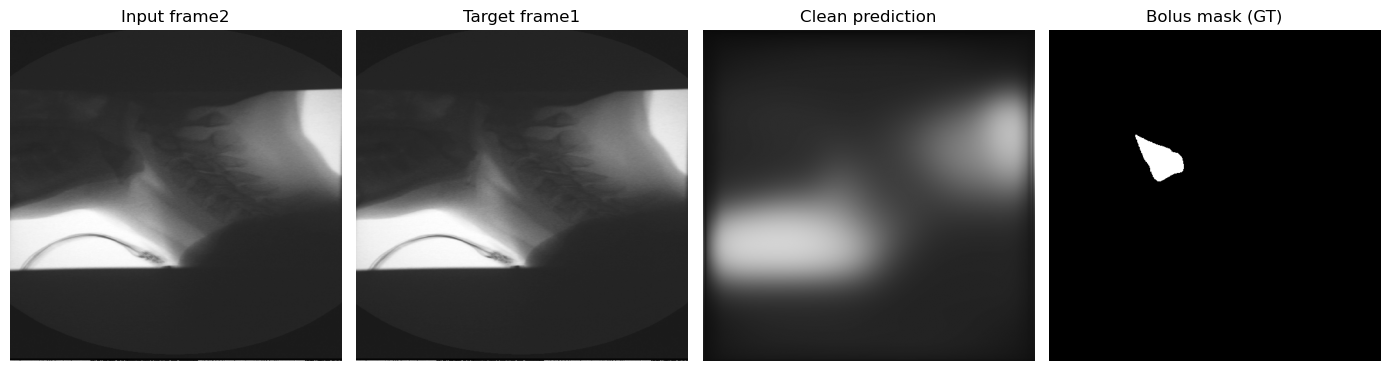

In [8]:
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)

model.eval()
test_losses = []
test_psnr = []
with torch.no_grad():
    for frame2, frame1, _ in data_loaders['test']:
        frame2, frame1 = [t.to(device) for t in (frame2, frame1)]
        pred = model(frame2)
        l1 = l1_loss(pred, frame1)
        mse = mse_loss(pred, frame1)
        test_losses.append(l1.item())
        test_psnr.append(psnr_from_mse(mse).item())

print(
    f"Test L1: {float(np.mean(test_losses)) if test_losses else float('nan'):.4f} | "
    f"Test PSNR: {float(np.mean(test_psnr)) if test_psnr else float('nan'):.2f}"
)

# quick qualitative sample (uses test split when available)
target_loader = data_loaders['test'] if len(splits['test']) else data_loaders['val']
with torch.no_grad():
    sample_batch = next(iter(target_loader))
    frame2, frame1, mask1 = [t.to(device) for t in sample_batch]
    pred = model(frame2).cpu().numpy()
    frame2 = frame2.cpu().numpy()
    frame1 = frame1.cpu().numpy()
    mask1 = mask1.cpu().numpy()

idx = 0
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
axes[0].imshow(frame2[idx, 0], cmap='gray')
axes[0].set_title('Input frame2')
axes[1].imshow(frame1[idx, 0], cmap='gray')
axes[1].set_title('Target frame1')
axes[2].imshow(pred[idx, 0], cmap='gray', vmin=0, vmax=1)
axes[2].set_title('Clean prediction')
axes[3].imshow(mask1[idx, 0], cmap='gray')
axes[3].set_title('Bolus mask (GT)')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()


In [9]:
torch.save(model.state_dict(), 'xf_clean_weights.pth')


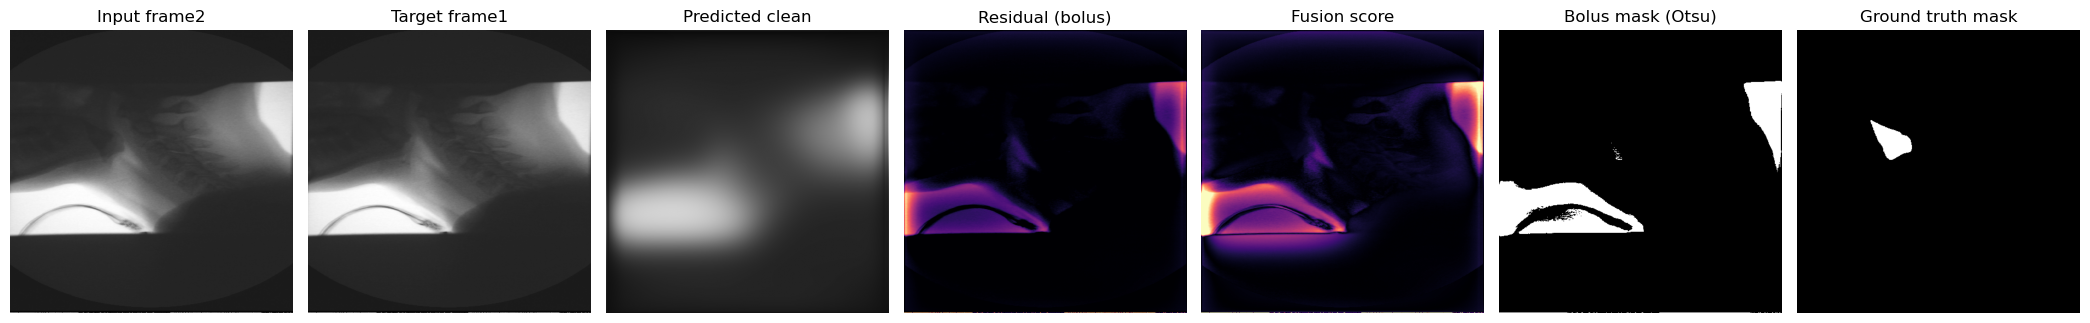

In [10]:
# Load saved clean-frame weights and estimate bolus mask via residual heuristics
CKPT_PATH = Path('xf_clean_weights.pth')

if not CKPT_PATH.exists():
    raise FileNotFoundError(f"Checkpoint not found: {CKPT_PATH}")

state = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

# prefer test loader if available
target_loader = data_loaders['test'] if len(splits['test']) else data_loaders['val']
with torch.no_grad():
    frame2, frame1, mask1 = [t.to(device) for t in next(iter(target_loader))]
    pred_clean = model(frame2).clamp(0, 1)
    residual = (frame1 - pred_clean).clamp(min=0)  # expected bolus contribution
    fusion = (residual + (frame2 - pred_clean).abs()).clamp(0, 1)

idx = 0
res_img = (residual[idx, 0].cpu().numpy() * 255).astype(np.uint8)
_, bolus_mask = cv2.threshold(res_img, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

fig, axes = plt.subplots(1, 7, figsize=(21, 4))
axes[0].imshow(frame2[idx, 0].cpu(), cmap='gray'); axes[0].set_title('Input frame2')
axes[1].imshow(frame1[idx, 0].cpu(), cmap='gray'); axes[1].set_title('Target frame1')
axes[2].imshow(pred_clean[idx, 0].cpu(), cmap='gray', vmin=0, vmax=1); axes[2].set_title('Predicted clean')
axes[3].imshow(residual[idx, 0].cpu(), cmap='magma'); axes[3].set_title('Residual (bolus)')
axes[4].imshow(fusion[idx, 0].cpu(), cmap='magma'); axes[4].set_title('Fusion score')
axes[5].imshow(bolus_mask, cmap='gray'); axes[5].set_title('Bolus mask (Otsu)')
axes[6].imshow(mask1[idx, 0].cpu(), cmap='gray'); axes[6].set_title('Ground truth mask')
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()


In [11]:
########## Load Unet
# === Load clean UNet from previous notebook ===
# from pathlib import Path

# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.block = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#         )
#     def forward(self, x): return self.block(x)

# class TinyUNet(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1, features=(16, 32, 64)):
#         super().__init__()
#         self.downs, self.pools = nn.ModuleList(), nn.ModuleList()
#         ch = in_channels
#         for feat in features:
#             self.downs.append(ConvBlock(ch, feat))
#             self.pools.append(nn.MaxPool2d(2))
#             ch = feat
#         self.bottleneck = ConvBlock(features[-1], features[-1] * 2)
#         self.upconvs, self.dec_blocks = nn.ModuleList(), nn.ModuleList()
#         decoder_in = features[-1] * 2
#         for feat in reversed(features):
#             self.upconvs.append(nn.ConvTranspose2d(decoder_in, feat, kernel_size=2, stride=2))
#             self.dec_blocks.append(ConvBlock(feat * 2, feat))
#             decoder_in = feat
#         self.final = nn.Conv2d(features[0], out_channels, kernel_size=1)

#     def forward(self, x):
#         skips = []
#         for down, pool in zip(self.downs, self.pools):
#             x = down(x); skips.append(x); x = pool(x)
#         x = self.bottleneck(x)
#         for up, dec, skip in zip(self.upconvs, self.dec_blocks, reversed(skips)):
#             x = up(x)
#             if x.shape[-2:] != skip.shape[-2:]:
#                 x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
#             x = torch.cat([skip, x], dim=1)
#             x = dec(x)
#         return torch.sigmoid(self.final(x))

# # instantiate and load weights
# unet_ckpt = Path("my_model_weights4.pth")  # adjust if your checkpoint filename differs
# if not unet_ckpt.exists():
#     raise FileNotFoundError(f"UNet checkpoint not found: {unet_ckpt}")

# clean_model = TinyUNet(in_channels=1, out_channels=1, features=(16, 32, 64)).to(device)
# state = torch.load(unet_ckpt, map_location=device)
# clean_model.load_state_dict(state)
# model = clean_model  # use UNet for fusion stage
# print(f"Loaded UNet clean model params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")


In [12]:
# Cross-frame fusion model: frame1 + clean prediction -> bolus mask (joint fine-tuning)
fusion_model = CrossFrameBolusNet(
    base=FUSION_BASE,
    heads=FUSION_HEADS,
    blocks=FUSION_BLOCKS,
).to(device)
attn_model = fusion_model

attn_optimizer = torch.optim.AdamW(
    [
        {'params': attn_model.parameters(), 'lr': FUSION_LR},
        {'params': model.parameters(), 'lr': CLEAN_FINE_LR},
    ],
    weight_decay=1e-4,
)
bce_loss = nn.BCEWithLogitsLoss()

def soft_dice_loss(logits, target, eps: float = 1e-6):
    p = torch.sigmoid(logits)
    inter = (p * target).sum(dim=(1, 2, 3))
    denom = p.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    return 1 - ((2 * inter + eps) / (denom + eps)).mean()

print(f"Fusion params: {count_params(attn_model)/1e6:.2f}M")

best_state = None
best_loss = float('inf')

for epoch in range(1, ATTN_EPOCHS + 1):
    model.train()
    attn_model.train()
    losses = []
    progress = tqdm(data_loaders['train'], desc=f"[Fusion] Epoch {epoch}", leave=False)
    for frame2, frame1, mask1 in progress:
        frame2, frame1, mask1 = [t.to(device) for t in (frame2, frame1, mask1)]
        clean_pred = model(frame2).clamp(0, 1)
        logits = attn_model(frame1, clean_pred)

        loss_bce = bce_loss(logits, mask1)
        loss_dice = soft_dice_loss(logits, mask1)
        loss = loss_bce + 1 * loss_dice       #### DICE

        attn_optimizer.zero_grad()
        loss.backward()
        attn_optimizer.step()
        losses.append(loss.item())
        progress.set_postfix(loss=f"{loss.item():.4f}")

    mean_loss = float(np.mean(losses))
    if mean_loss < best_loss:
        best_loss = mean_loss
        best_state = {k: v.cpu() for k, v in attn_model.state_dict().items()}
        torch.save(best_state, "xf_fusion_best.pth")
    print(f"[Fusion] Epoch {epoch} BCE: {loss_bce.item():.4f} | Dice: {loss_dice.item():.4f}")

# quick eval/visualization
model.eval()
attn_model.eval()
target_loader = data_loaders['test'] if len(splits['test']) else data_loaders['val']
with torch.no_grad():
    frame2, frame1, mask1 = [t.to(device) for t in next(iter(target_loader))]
    clean_pred = model(frame2).clamp(0, 1)
    bolus_logits = attn_model(frame1, clean_pred)
    bolus_prob = torch.sigmoid(bolus_logits)

idx = 0
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
axes[0].imshow(frame1[idx, 0].cpu(), cmap='gray'); axes[0].set_title('Frame1')
axes[1].imshow(frame2[idx, 0].cpu(), cmap='gray'); axes[1].set_title('Frame2')
axes[2].imshow(clean_pred[idx, 0].cpu(), cmap='gray', vmin=0, vmax=1); axes[2].set_title('Clean pred')
axes[3].imshow(mask1[idx, 0].cpu(), cmap='gray'); axes[3].set_title('GT bolus')
axes[4].imshow(bolus_prob[idx, 0].cpu(), cmap='magma', vmin=0, vmax=1); axes[4].set_title('Fusion bolus prob')
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()


Fusion params: 0.15M


[Fusion] Epoch 1:   0%|          | 0/1079 [00:00<?, ?it/s]

RuntimeError: srcNDArray INTERNAL ASSERT FAILED at "/Users/runner/miniforge3/conda-bld/libtorch_1760336151443/work/aten/src/ATen/native/mps/OperationUtils.mm":517, please report a bug to PyTorch. 

In [ ]:
# Evaluate fusion bolus model: IoU, Dice (DSC), AUC
from sklearn.metrics import roc_auc_score

if best_state is not None:
    attn_model.load_state_dict(best_state)
    attn_model.to(device)
    
attn_model.eval()
target_loader = data_loaders['test'] if len(splits['test']) else data_loaders['val']

total_iou = []
total_dice = []
all_probs = []
all_targets = []

with torch.no_grad():
    for frame2, frame1, mask1 in target_loader:
        frame2, frame1, mask1 = [t.to(device) for t in (frame2, frame1, mask1)]
        clean_pred = model(frame2).clamp(0, 1)
        logits = attn_model(frame1, clean_pred)
        prob = torch.sigmoid(logits).clamp(0, 1)

        pred_bin = (prob >= 0.5).float()
        intersection = (pred_bin * mask1).sum(dim=(1, 2, 3))
        union = pred_bin.sum(dim=(1, 2, 3)) + mask1.sum(dim=(1, 2, 3)) - intersection
        dice = (2 * intersection) / (pred_bin.sum(dim=(1, 2, 3)) + mask1.sum(dim=(1, 2, 3))).clamp_min(1e-6)
        iou = intersection / union.clamp_min(1e-6)

        total_iou.extend(iou.cpu().numpy().tolist())
        total_dice.extend(dice.cpu().numpy().tolist())
        all_probs.append(prob.cpu().numpy().reshape(-1))
        all_targets.append(mask1.cpu().numpy().reshape(-1))

all_probs = np.concatenate(all_probs) if all_probs else np.array([])
all_targets = np.concatenate(all_targets) if all_targets else np.array([])

if all_probs.size == 0:
    auc = float('nan')
elif np.unique(all_targets).size < 2:
    auc = float('nan')
else:
    auc = roc_auc_score(all_targets, all_probs)

print(
    f"Fusion IoU: {float(np.mean(total_iou)) if total_iou else float('nan'):.4f} | "
    f"Fusion Dice: {float(np.mean(total_dice)) if total_dice else float('nan'):.4f} | "
    f"Fusion AUC: {auc if not np.isnan(auc) else float('nan'):.4f}"
)
